In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

Tutorial link: https://www.tensorflow.org/tutorials/structured_data/feature_columns

In [3]:
dataframe = pd.read_csv("final.csv")

In [4]:
dataframe.dropna(inplace=True)

In [5]:
dataframe['target'] = dataframe['MB']

In [6]:
dataframe = dataframe.drop(['MB'], axis=1)

In [7]:
X = dataframe.drop(['target'], axis=1)
y = dataframe['target']

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
train_resampled = X_train_resampled.copy()
train_resampled['target'] = y_train_resampled

In [11]:
feature_columns = []

for header in ["q8", "q9", "q10", "q11", "q12", "q17",	"q19", "q26", "q27", "q28",	"q29", "q30", "q31", "q35", "q38", "q39", "q46", "q49", "q50", "q51", "q52", "q53", "q54", "q55",	"q58", "q59", "q60", "q61",	"q74", "q75", "q79", "q80", "q81", "q82", "q84", "q85", "q87", "q92"]:
    feature_columns.append(feature_column.numeric_column(header))


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [12]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer = tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],))  # This is for numeric inputs


In [13]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train_resampled, y_train_resampled)).shuffle(buffer_size=len(X_train_resampled)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [14]:
model = tf.keras.Sequential([
    input_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])

In [15]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)

# Creating a dictionary of class weights
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print(f"Class weights: {class_weight_dict}")

Class weights: {0.0: 0.6032059727711901, 1.0: 2.9223404255319148}


In [16]:
def specificity(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), 'float'))
    false_positives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), 'float'))
    
    specificity = true_negatives / (true_negatives + false_positives + tf.keras.backend.epsilon())
    return specificity

In [17]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC(name='auc'),
                  specificity,
                  tf.keras.metrics.Recall(name='sensitivity'),
                  f1_score
                      ]
             )

In [19]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict
)

Epoch 1/10
712/712 [==============================] - 1s 948us/step - loss: 0.1366 - accuracy: 0.9389 - auc: 0.9581 - specificity: 0.8517 - sensitivity: 0.9899 - f1_score: 0.9329 - val_loss: 0.0794 - val_accuracy: 0.9709 - val_auc: 0.9818 - val_specificity: 0.9569 - val_sensitivity: 0.9780 - val_f1_score: 0.8910
Epoch 2/10
712/712 [==============================] - 1s 740us/step - loss: 0.0512 - accuracy: 0.9795 - auc: 0.9837 - specificity: 0.9525 - sensitivity: 0.9975 - f1_score: 0.9754 - val_loss: 0.1419 - val_accuracy: 0.9516 - val_auc: 0.9757 - val_specificity: 0.9285 - val_sensitivity: 0.9973 - val_f1_score: 0.8442
Epoch 3/10
712/712 [==============================] - 1s 756us/step - loss: 0.0381 - accuracy: 0.9846 - auc: 0.9881 - specificity: 0.9668 - sensitivity: 0.9968 - f1_score: 0.9823 - val_loss: 0.1153 - val_accuracy: 0.9623 - val_auc: 0.9811 - val_specificity: 0.9500 - val_sensitivity: 0.9945 - val_f1_score: 0.8812
Epoch 4/10
712/712 [==============================] - 1s 7

In [20]:
model.evaluate(
    test_ds,
)

123/123 [==============================] - 0s 499us/step - loss: 0.0393 - accuracy: 0.9855 - auc: 0.9790 - specificity: 0.9898 - sensitivity: 0.9595 - f1_score: 0.9590


[0.03929440677165985,
 0.9854776859283447,
 0.9790403842926025,
 0.9897704720497131,
 0.9595141410827637,
 0.9589589238166809]

In [21]:
import shap


In [22]:
background_data = shap.kmeans(X_train, 10)  # Use 10 clusters, adjust as necessary
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

1/1 [==============================] - 0s 50ms/step


  0%|          | 0/3925 [00:00<?, ?it/s]

664/664 [==============================] - 0s 558us/step


In [23]:
shap_values_reshaped = np.squeeze(shap_values)  # Removes the last dimension
print(shap_values_reshaped.shape)

(3925, 38)


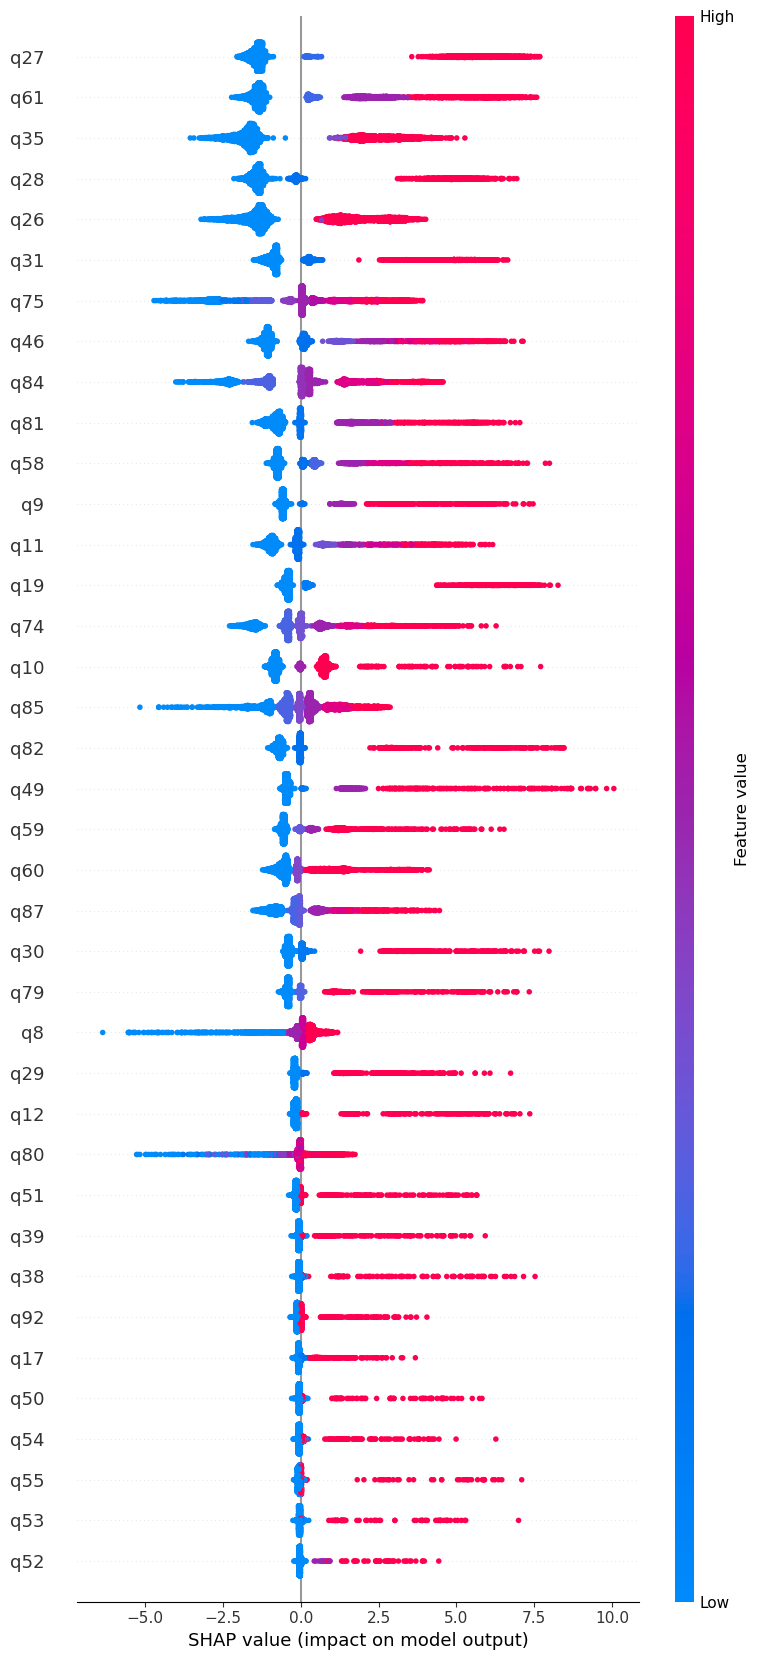

In [24]:
shap.summary_plot(shap_values_reshaped, X_test, max_display=X_test.shape[1])